In [23]:
# Importing the necessary libraries.
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import dateutil.parser
import os

In [24]:
# Creating a path to the dataset using Pathlib
current_directory = os.getcwd()
dataset_path = Path(current_directory) / 'all_2022.csv'
# Loading the CSV file into a Pandas DataFrame
data = pd.read_csv(dataset_path)

# 1. Give an overview of the top 10 agents in terms of traded volumes

To provide an overview of the top 10 agents in terms of traded volumes, I'll do the following:
1.	Combine the buying and selling volumes for each agent.
2.	Aggregate the volumes to get the total volume for each agent.
3.	Sort the agents by their total traded volumes in descending order.
4.	Display the top 10 agents.

In [25]:
# Calculating traded volumes for each agent as a buyer and as a seller
# For each unique buy_agent (which refers to each unique agent buying energy), the following line will group all rows with that agent together.
# After grouping the rows by buy_agent, ['energy'].sum() calculates the sum of the energy column for each group.
# Using reset_index() to transform back 'buy_agent' into a regular column, so a new default integer index is set.
buy_volumes = data.groupby('buy_agent')['energy'].sum().reset_index()
buy_volumes.columns = ['agent', 'buy_volume']

sell_volumes = data.groupby('sell_agent')['energy'].sum().reset_index()
sell_volumes.columns = ['agent', 'sell_volume']

# Merging the buy and sell volumes based on the agent.
# The pd.merge() function is used to merge two DataFrames based on common columns or indices.
merged_volumes = pd.merge(buy_volumes, sell_volumes, on='agent', how='outer').fillna(0)
# First DataFrame: buy_volumes. Second DataFrame: sell_volumes.
# on='agent' specifies the column that should be used to match rows between the two DataFrames.
# how='outer' specifies the type of merge to be performed.
# 'outer' means that the resulting DataFrame will have all the agents present in both DataFrames.
# If an agent is only present in one DataFrames, the missing values will be filled with NaN.
# 'fillna(0)' is used to replace all these NaN values with zeros.

# Calculating total traded volume for each agent.
# This part of the code is creating a new column named 'total_volume' in the merged_volumes DataFrame.
merged_volumes['total_volume'] = merged_volumes['buy_volume'] + merged_volumes['sell_volume']
#For each agent, the code is computing the total energy volume they were involved in (both buying and selling) and storing this combined volume in the 'total_volume' column.


# Sorting by total traded volume in descending order and display the top 10 agents
top_10_vol_agents = merged_volumes.sort_values(by='total_volume', ascending=False).head(10)

top_10_vol_agents

,agent,buy_volume,sell_volume,total_volume
84,IBGES,632072.8,695148.2,1327221.0
70,GESTE,380424.2,553572.6,933996.8
132,SOREX,361439.0,491260.1,852699.1
41,EDPGP,412072.6,253904.9,665977.5
71,GNCO,209324.0,413913.5,623237.5
38,ECYR,267801.0,255169.3,522970.3
82,HISPE,242938.7,272882.5,515821.2
72,GNRA,193593.9,220758.5,414352.4
53,ENDG,168698.7,181042.1,349740.8
80,HC G,195132.7,106751.3,301884.0


# 2. Calculate an hourly Volume-Weighted Average Price (vwap).

The Volume-Weighted Average Price (VWAP) is a common indicator used in trading, representing the average price a security has traded at throughout the day, based on both volume and price.

To calculate the hourly VWAP, I would group the data by the hour and then apply the VWAP formula for each group.

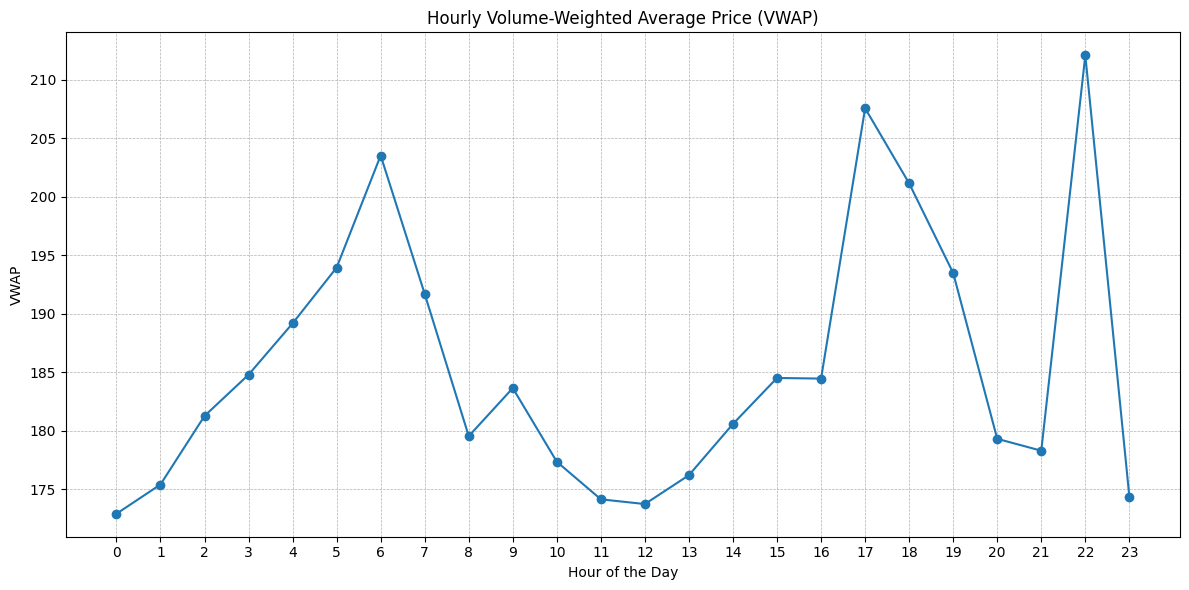

In [26]:
# 1. Data Parsing
# The code is transforming any strings in the 'timestamp' column of the original DataFrame into actual datetime objects.
# If there's any string that can't be converted, it's replaced with a missing datetime value (NaT).
def parse_date(val):
    try:
        return dateutil.parser.parse(val)
    except:
        return pd.NaT

data['timestamp'] = data['timestamp'].apply(parse_date)

# 2. Extract hour from timestamp and store it in a new column.
data['hour'] = data['timestamp'].dt.hour

# 3. Data Cleaning
# Removing rows containing missing values (NaN values) in the specified columns.
data.dropna(subset=['price', 'energy', 'timestamp'], inplace=True)
# Filtering out rows from the DataFrame where the value in the 'energy' column is equal to 0.
data = data[data['energy'] != 0]
# After executing these lines, the DataFrame will not have any rows with missing values in the 'price', 'energy', or 'timestamp' columns.
# It will also not have any rows where the 'energy' value is 0.

# 4. Calculate the product of price and energy by creating a new column in the DataFrame named price_times_energy.
data['price_times_energy'] = data['price'] * data['energy']

# 5. Group by hour and calculate aggregates by using the groupby method.
# data.groupby('hour') creates a collection of smaller DataFrames, where each smaller DataFrame consists of rows with the same hour value.
# .agg(...) is an aggregation function that computes specified aggregate values for each of the grouped DataFrames (each 'hour' group in this context).
# sum_price_times_energy=('price_times_energy', 'sum') computes the sum of the price_times_energy values for each 'hour' group.
# sum_energy=('price_times_energy', 'sum') computes the sum of the energy values for each 'hour' group.
grouped = data.groupby('hour').agg(
    sum_price_times_energy=('price_times_energy', 'sum'),
    sum_energy=('energy', 'sum')
).reset_index()
# By default, after a groupby operation, the column used for grouping (hour) becomes the index of the resulting DataFrame.
# The reset_index() function is used to reset the index of the DataFrame and make hour a regular column again.
# After executing this part of the code I get a new DataFrame with the columns 'hour', 'sum_price_times_energy' and 'sum_energy'.
# It essentially provides a summary of the data, grouped by hour, showing the total price_times_energy and total energy for each hour.

# 6. Calculate VWAP
# This creates a column named vwap in the grouped DataFrame.
grouped['vwap'] = grouped['sum_price_times_energy'] / grouped['sum_energy']


# 7. Data Visualization
plt.figure(figsize=(12, 6))
plt.plot(grouped['hour'], grouped['vwap'], marker='o')
plt.title("Hourly Volume-Weighted Average Price (VWAP)")
plt.xlabel("Hour of the Day")
plt.ylabel("VWAP")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(grouped['hour'])
plt.tight_layout()

plt.show()

The division **grouped['sum_price_times_energy'] / grouped['sum_energy']** calculates the *VWAP*. It's essentially finding the average price of energy traded in each hour, weighted by the volume of energy traded. In simpler terms, if you think of energy as a product you're buying, the VWAP tells you the average price you paid for it, considering all transactions within that hour.

In financial markets, *VWAP* is a popular metric used by traders and algorithms to determine the average price a security has traded at throughout the day, based on both volume and price. In this context, it's being applied to the energy market to determine the average price of energy traded during each hour.

In [27]:
# This line of code is selecting specific columns from the grouped DataFrame and creating a new DataFrame called hourly_vwap.
# The new DataFrame called hourly_vwap will contain just the 'hour' and 'vwap' columns.
hourly_vwap = grouped[['hour', 'vwap']]
hourly_vwap

,hour,vwap
0,0,172.908484
1,1,175.410707
2,2,181.267347
3,3,184.793999
4,4,189.178488
5,5,193.947080
6,6,203.523886
7,7,191.693741
8,8,179.541438
9,9,183.649532


Qualitative interpretation based on the results.

1.	Nighttime Hours (0-6 hours):

•	Electrical trades in the early hours are typically lower in volume. However, the volume-weighted average price gradually rises.

This could be due to:

•	Reduced supply from renewable generation sources (like solar).

•	Increased reliance on more expensive energy sources or imports.

•	Traders adjusting their positions and gearing up for the daily market session at 12:00 CET.

2.	Morning (7-12 hours):

•	In the hours leading up to the 12:00 CET daily market session, there's some volatility. The dip until 8:00 might be a position adjustment in anticipation of the session. The steadiness leading up to noon suggests a balance in supply and demand expectations.

3.	Afternoon (13-17 hours):

•	Post the daily market session, there's a spike in the VWAP, possibly reflecting the outcomes of trades agreed upon in that session.

The variations in these hours could be influenced by:

•	Changes in interconnection and cross-border energy flow.

•	Real-time energy demand shifts.

•	Additional information or shifts in expectations that weren't available during the daily market session.

4.	Evening (18-23 hours):

•	The significant peak at 22:00 might indicate some specific event in the market, possibly a surge in demand or a dip in supply, driving prices up.

This could be linked to:

•	Changes in interconnection and transmission capacity.

•	System balancing needs, especially if there are intermittent generation sources.

Considering the price limits and thresholds from https://www.omie.es/es/mercado-de-electricidad, it's clear that the prices we're seeing are well within the limits set for offers in the daily market. However, if they ever approach the notification thresholds, it might be cause for deeper analysis to understand the reasons behind such an event.

In [28]:
print(data.head(0))

Empty DataFrame
Columns: [raw, date, contract, buy_agent, buy_uof, buy_zone, sell_agent, sell_uof, sell_zone, price, energy, timestamp, contract_start, contract_end, hour, price_times_energy]
Index: []


# 3. Score agents' trades according to their spread with vwap.

In [29]:
# 1. Calculating VWAP for each hour
vwap = data.groupby('hour').apply(lambda x: x['price_times_energy'].sum() / x['energy'].sum()).reset_index(name='vwap')


In [30]:

# 2. Merging VWAP with main dataframe
# This line of code merges the original DataFrame with the vwap DataFrame based on the 'hour' column, using a left join.
# A 'left' merge means that all the rows from the data DataFrame (left DataFrame) will be kept.
data = data.merge(vwap, on='hour', how='left')


In [31]:

# 3. Calculating scores for buy and sell agents based on the spread from VWAP.

# For each row in the data, the code checks if the price is less than the VWAP.
# If it is, give it a score of 1. If it's not, give it a score of -1.
# Then, store all these scores in a new column named 'buy_score'.

# For buy trades: Score 1 if trade price is below VWAP, else -1
data['buy_score'] = data.apply(lambda row: 1 if row['price'] < row['vwap'] else -1, axis=1)

# Repeating the same process for the sells.
# For sell trades: Score 1 if trade price is above VWAP, else -1
data['sell_score'] = data.apply(lambda row: 1 if row['price'] > row['vwap'] else -1, axis=1)



In [32]:
# 4. Aggregating scores for each agent
buy_scores = data.groupby('buy_agent')['buy_score'].sum().reset_index()
sell_scores = data.groupby('sell_agent')['sell_score'].sum().reset_index()

In [33]:
# Merging buy and sell scores for each agent and summing them up.
# Taking two tables (buy_scores and sell_scores) and combining them into one table (scores) based on the agent's ID.
scores = buy_scores.merge(sell_scores, left_on='buy_agent', right_on='sell_agent', how='outer')
# Replacing missing values with the number 0.
scores.fillna(0, inplace=True)  # To handle cases where an agent either only bought or sold
# This line of the code is summing the values in the 'buy_score' and 'sell_score' columns for each agent (or row) and storing the result in a new column named 'total_score'.
scores['total_score'] = scores['buy_score'] + scores['sell_score']
scores['agent_id'] = np.where(scores['buy_agent'].isnull(), scores['sell_agent'], scores['buy_agent'])
scores = scores[['agent_id', 'total_score']]

print(scores)

    agent_id  total_score
0      ABOUT        -19.0
1      ACCGR       -138.0
2      ADELF          3.0
3      ADXRE          7.0
4      AENER         10.0
..       ...          ...
161        0         -6.0
162        0          5.0
163        0       -290.0
164        0         -5.0
165        0         -2.0

[166 rows x 2 columns]


Trades with "empty" (zero) counterparties represent cross-border trades, i.e., trades that occur across the border of the OMIE scope. These trades are only partially handled by OMIE, so the details of the counterparty aren't published.

In [34]:
# Sorting the total_scores in the scores DataFrame
sorted_scores = scores.sort_values(by='total_score', ascending=False)

# Displaying the top 10 agents with the best scores
top_10_agents = sorted_scores.head(10)
print("Top 10 Agents with Best Total Scores:")
print(top_10_agents)

# Displaying the bottom 10 agents with the worst scores
bottom_10_agents = sorted_scores.tail(10)
print("\nBottom 10 Agents with Worst Total Scores:")
print(bottom_10_agents)

Top 10 Agents with Best Total Scores:
    agent_id  total_score
34     DETIC      54375.0
41     EDPGP      35166.0
84     IBGES      30795.0
72      GNRA      13475.0
70     GESTE       9141.0
22       CEG       8563.0
42     EENER       7415.0
126    SEDAE       5235.0
58     ENUFR       4370.0
47      EGED       4072.0

Bottom 10 Agents with Worst Total Scores:
    agent_id  total_score
65     FORTI      -2788.0
15      BBEL      -3408.0
26     CLIDM      -4474.0
80      HC G      -4859.0
132    SOREX      -7638.0
138    TAUTR      -8739.0
82     HISPE      -9903.0
110     NEXU     -12044.0
83     HSATE     -12115.0
38      ECYR     -19596.0


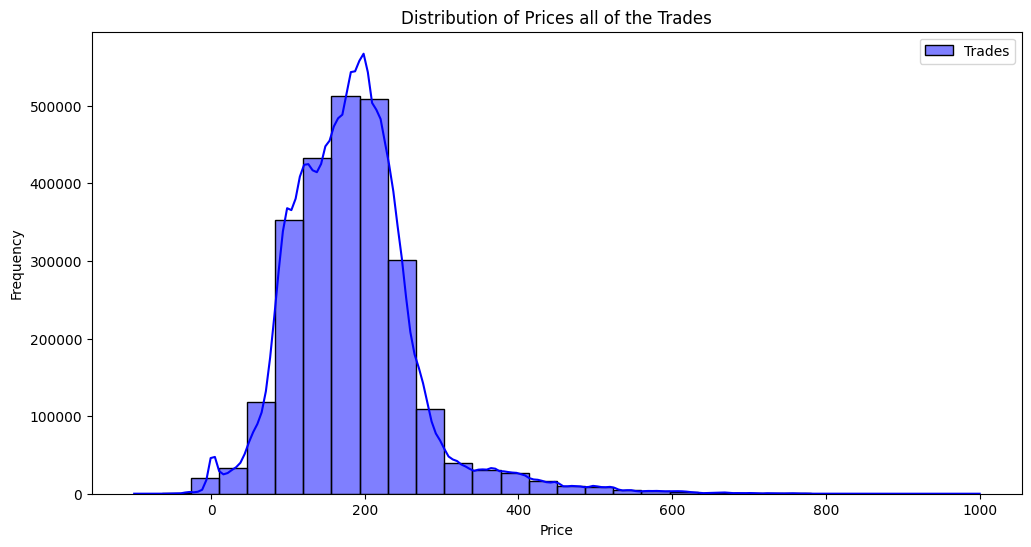

In [49]:
# Plotting the distribution of prices for all of the trades:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(internal_trades['price'], color='blue', kde=True, label='Trades', bins=30)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Prices all of the Trades')
plt.legend()
plt.show()

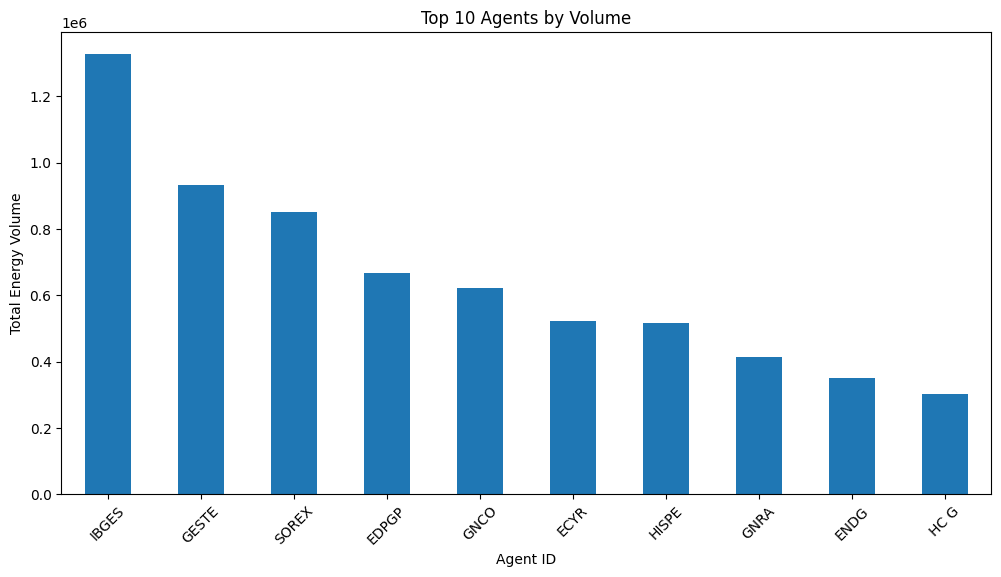

In [50]:
# Top 10 agents by Volume:
# Combining buy and sell agents and calculating total energy volume.
agents_volume = data.groupby('buy_agent')['energy'].sum().add(data.groupby('sell_agent')['energy'].sum(), fill_value=0)
top_10_agents = agents_volume.sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_10_agents.plot(kind='bar')
plt.xlabel('Agent ID')
plt.ylabel('Total Energy Volume')
plt.title('Top 10 Agents by Volume')
plt.xticks(rotation=45)
plt.show()

It would require further analysis to see if there's a difference in performance between internal and cross-border trades, comparing metrics like:

· Volume: Comparing the total energy volume traded internally versus cross-border.

· Value: Calculating the total value of trades internally versus cross-border.

· Average Price: Computing the average price for internal trades and cross-border trades.

· Frequency: Checking how often internal trades occur compared to cross-border trades.